## Telegraph model of gene expression

### Definitions

Each gene is considered either inactive ("off") or active ("on").

It can switch between from the "on" to the "off" state with rate $k_{off}$ and from the "off" to the "on" state with rate $k_{on}$.

When  the gene is "on", it produces mRNA at a rate $k_{syn}$.

mRNA degrades iteself at a rate $k_{deg}$.

<div>
<img src="../images/kse_telegraph_model_wbg.png" width="700" data-background-color="white"/>
</div>

### Model simulations with the PYSB package

Load libraries

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from pysb import Model, Monomer, Parameter, Initial, Expression, Rule, Observable
from pysb.simulator.bng import BngSimulator

Create a PySB model with one gene and one RNA type

In [98]:
class PYSBTelegraph:
    def __init__(self, k_on, k_off, k_syn, k_deg):
        self.model = Model()
        self.build_model(k_on, k_off, k_syn, k_deg)

    def build_model(self, k_on, k_off, k_syn, k_deg):
        Monomer(f"Gene", ["state"], {"state": ["ON", "OFF"]})
        Monomer(f"RNA")
        Initial(
            self.model.monomers[f"Gene"](state="OFF"),
            Parameter(f"Gene_0", 1),
        )
        Initial(
            self.model.monomers[f"RNA"](),
            Parameter(f"RNA_0", 0.0),
        )
        Observable(f"Gene_ON", self.model.monomers[f"Gene"](state="ON"))
        Observable(f"RNA_count", self.model.monomers[f"RNA"]())

        Parameter('k_on', k_on)
        Parameter('k_off', k_off)
        Parameter('k_syn', k_syn)
        Parameter('k_deg', k_deg)

        Expression("Rate_synthesis", self.model.parameters['k_syn'] * self.model.observables['Gene_ON'])

        Rule("Gene_activation", self.model.monomers[f"Gene"](state="OFF") >> self.model.monomers[f"Gene"](state="ON"), self.model.parameters['k_on'])
        Rule("Gene_deactivation", self.model.monomers[f"Gene"](state="ON") >> self.model.monomers[f"Gene"](state="OFF"), self.model.parameters['k_off'])
        Rule("RNA_synthesis", None >> self.model.monomers[f"RNA"](), self.model.expressions['Rate_synthesis'])
        Rule("RNA_degradation", self.model.monomers[f"RNA"]() >> None, self.model.parameters['k_deg'])

    def run_ssa(self, tspan, n_runs):
        print("Simulating with SSA algorithm...")
        sim = BngSimulator(self.model)
        self.ssa = sim.run(
            tspan=tspan, n_runs=n_runs, method="ssa", verbose=True
        )

Simulating with SSA algorithm...


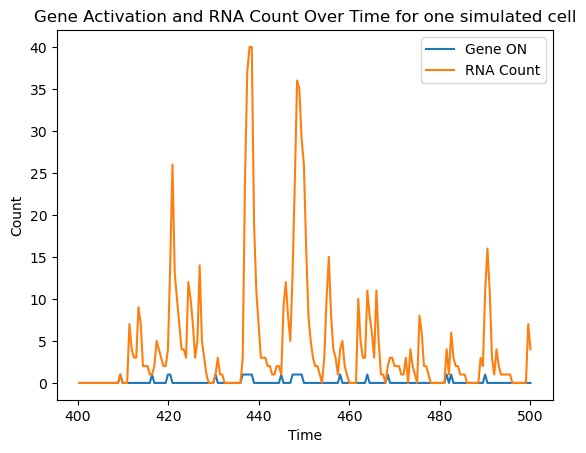

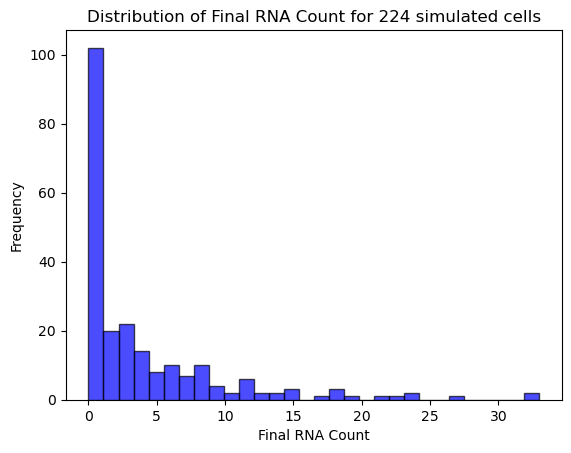

In [142]:
mymodel = PYSBTelegraph(k_on=0.5, k_off=4.0, k_syn=40.0, k_deg=1.0)
#mymodel = PYSBTelegraph(k_on=4.0, k_off=0.5, k_syn=40.0, k_deg=1.0)

mymodel.run_ssa(tspan=np.linspace(0, 500, 1000), n_runs=224)
plt.plot(mymodel.ssa.tout[0][800:], mymodel.ssa.observables[0]["Gene_ON"][800:], label='Gene ON')
plt.plot(mymodel.ssa.tout[0][800:], mymodel.ssa.observables[0]["RNA_count"][800:], label='RNA Count')
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('Gene Activation and RNA Count Over Time for one simulated cell')
plt.legend()
plt.show()

plt.hist([mymodel.ssa.observables[i]["RNA_count"][999] for i in range(len(mymodel.ssa.observables))], bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Final RNA Count')
plt.ylabel('Frequency')
plt.title('Distribution of Final RNA Count for 224 simulated cells')
plt.show()